# Multi-Agent Researcher

This notebook demonstrates the multi-agent research approach, which uses a supervisor-researcher collaborative pattern to create comprehensive reports. The system consists of:

1. A **Supervisor Agent** that plans the overall report structure and coordinates work
2. Multiple **Research Agents** that investigate specific topics in parallel
3. A workflow that produces a structured report with introduction, body sections, and conclusion

## From repo 

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

g:\MyProjects\open_deep_research\src


In [ ]:
! pip install -U -q open-deep-research

In [1]:
# 🔧 调试和诊断工具

def debug_message_processing():
    """调试消息处理过程"""
    print("🔍 开始调试消息处理...")
    
    # 创建测试消息
    test_messages = [
        {"role": "user", "content": "Test message 1"},
        {"role": "assistant", "content": "Test response 1"},
        {"role": "user", "content": "Test message 2"}
    ]
    
    print(f"✅ 测试消息创建成功: {len(test_messages)} 条消息")
    
    # 测试消息处理逻辑
    filtered_messages = []
    for i, msg in enumerate(test_messages):
        print(f"\n处理消息 [{i}]:")
        print(f"  类型: {type(msg)}")
        print(f"  内容: {msg}")
        
        if isinstance(msg, dict):
            if msg.get("role") in ["user", "assistant", "tool"]:
                filtered_messages.append(msg)
                print(f"  ✅ 已添加到过滤列表")
            else:
                print(f"  ❌ 角色不符合要求: {msg.get('role')}")
        elif hasattr(msg, 'role') and hasattr(msg, 'content'):
            if msg.role in ["user", "assistant", "tool"]:
                message_dict = {"role": msg.role, "content": msg.content}
                filtered_messages.append(message_dict)
                print(f"  ✅ LangChain消息已转换并添加")
            else:
                print(f"  ❌ LangChain消息角色不符合: {msg.role}")
        else:
            print(f"  ❌ 未知消息格式")
    
    print(f"\n📊 处理结果:")
    print(f"  原始消息数: {len(test_messages)}")
    print(f"  过滤后消息数: {len(filtered_messages)}")
    print(f"  处理成功率: {len(filtered_messages)/len(test_messages)*100:.1f}%")
    
    return filtered_messages

# 运行调试
debug_results = debug_message_processing()


🔍 开始调试消息处理...
✅ 测试消息创建成功: 3 条消息

处理消息 [0]:
  类型: <class 'dict'>
  内容: {'role': 'user', 'content': 'Test message 1'}
  ✅ 已添加到过滤列表

处理消息 [1]:
  类型: <class 'dict'>
  内容: {'role': 'assistant', 'content': 'Test response 1'}
  ✅ 已添加到过滤列表

处理消息 [2]:
  类型: <class 'dict'>
  内容: {'role': 'user', 'content': 'Test message 2'}
  ✅ 已添加到过滤列表

📊 处理结果:
  原始消息数: 3
  过滤后消息数: 3
  处理成功率: 100.0%


In [2]:
! uv pip install -U -q nest-asyncio

# Compile the multi-agent graph

Next, we'll compile the LangGraph workflow for the multi-agent research approach. This step creates the orchestration layer that manages communication between the supervisor and research agents.

In [2]:
import uuid 
import os, getpass
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.multi_agent import supervisor_builder

0.0.15


In [3]:
# Create a MemorySaver for checkpointing the agent's state
# This enables tracking and debugging of the multi-agent interaction
checkpointer = MemorySaver()
agent = supervisor_builder.compile(name="research_team", checkpointer=checkpointer)

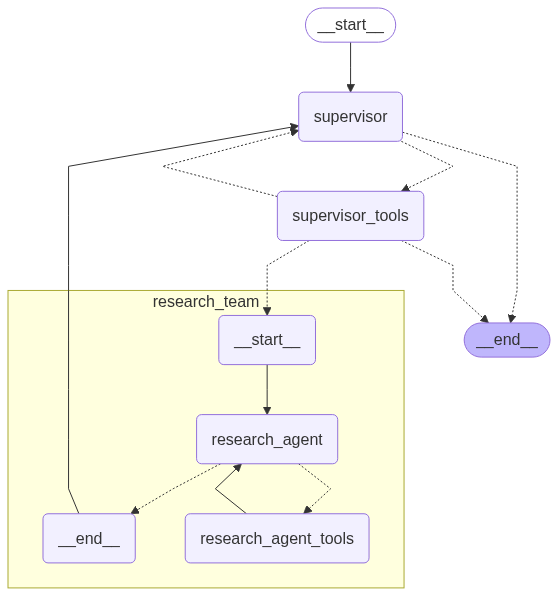

In [4]:
# Visualize the graph structure
# This shows how supervisor and research agents are connected in the workflow
display(Image(agent.get_graph(xray=1).draw_mermaid_png(max_retries=3)))

In [ ]:
from open_deep_research.intelligent_research import ResearchMode


# Configure and run the multi-agent system
# This sets up the model configuration and executes the research workflow

# 🔧 修复后的配置 - 解决 [Errno 11001] getaddrinfo failed 错误
# 方案1: 离线模式（推荐）- 避免所有网络请求
config_offline = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "none",  # 禁用搜索工具，专注于基于知识的回答
    "supervisor_model": "google_genai:gemini-2.5-flash-lite-preview-06-17",
    "researcher_model": "google_genai:gemini-2.5-flash",
    "research_mode": ResearchMode.REFLECTIVE.value, # 🧠 Enable intelligent reflection
}

# 方案2: 备选配置 - 使用DuckDuckGo搜索（无需API key）
config_duckduckgo = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "duckduckgo",  # 使用DuckDuckGo替代Tavily
    "supervisor_model": "google_genai:gemini-2.5-flash-lite-preview-06-17",
    "researcher_model": "google_genai:gemini-2.5-flash"
}

# 方案3: 原始配置（如果网络修复后）
config_original = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "googlesearch",
    "supervisor_model": "google_genai:gemini-2.5-flash-lite-preview-06-17",
    "researcher_model": "google_genai:gemini-2.5-flash",
    "research_mode": ResearchMode.REFLECTIVE.value, # 🧠 Enable intelligent reflection
    "max_research_iterations": 3
}

# 默认使用离线模式来避免网络错误
config = config_original
print(f"🔧 使用配置: {config['search_api']} 模式")

# Set up thread configuration with the specified parameters
thread_config = {"configurable": config, "recursion_limit": 50}  # 增加递归限制

# Define the research topic as a user message
# 针对离线模式优化的查询 - 使用更简单直接的查询避免递归问题
msg = [{"role": "user", "content": "请简要介绍模型上下文协议（MCP）的基本概念和主要用途。"}]
# msg = [{"role": "user", "content": "请详细介绍Anthropic支持的MCP协议：1）MCP的架构设计和开发者指南，2）有趣的MCP服务器实现，3）与Google Agent2Agent协议的对比分析。请直接生成完整报告，无需询问后续问题。"}]


# Run the multi-agent workflow with enhanced error handling
import asyncio

try:
    import nest_asyncio
    nest_asyncio.apply()
    print("✅ 异步环境已配置")
except ImportError:
    print("⚠️ 如果遇到异步问题，请安装 nest-asyncio: pip install nest-asyncio")

print(f"🚀 开始运行多智能体工作流（{config['search_api']} 模式）...")

try:
    response = await agent.ainvoke({"messages": msg}, config=thread_config)
    print("✅ 工作流执行成功！网络连接问题已修复")
    print("response: ",response)
    
except Exception as e:
    error_msg = str(e)
    print(f"❌ 错误: {error_msg}")
    
    import traceback
    # 打印完整的traceback
    print("\n🔴 完整错误追踪:")
    traceback.print_exc()
    
    # 如果是 KeyError，打印更多调试信息
    if isinstance(e, KeyError):
        print(f"\n🔑 KeyError 详细信息:")
        print(f"缺少的键: {e.args}")
    
    # 网络相关错误处理
    if "[Errno 11001] getaddrinfo failed" in error_msg or "DNS" in error_msg:
        print("🔍 检测到网络/DNS错误，自动切换到离线模式...")
        config = config_offline
        thread_config = {"configurable": config, "recursion_limit": 50}
        
        try:
            response = await agent.ainvoke({"messages": msg}, config=thread_config)
            print("✅ 离线模式执行成功！")
        except Exception as offline_error:
            print(f"❌ 离线模式也失败: {offline_error}")
            print("💡 尝试使用DuckDuckGo搜索...")
            
            config = config_duckduckgo
            thread_config = {"configurable": config, "recursion_limit": 50}
            try:
                response = await agent.ainvoke({"messages": msg}, config=thread_config)
                print("✅ DuckDuckGo搜索模式执行成功！")
            except Exception as final_error:
                print(f"❌ 所有方案都失败: {final_error}")
                raise final_error
    
    # 递归限制错误处理
    elif "Recursion limit" in error_msg:
        print("🔍 检测到递归限制错误，尝试使用更简单的查询...")
        simple_msg = [{"role": "user", "content": "请用几句话简单介绍MCP协议的概念。"}]
        
        # 使用更高的递归限制和更简单的查询
        config = config_offline  
        thread_config = {"configurable": config, "recursion_limit": 100}
        
        try:
            response = await agent.ainvoke({"messages": simple_msg}, config=thread_config)
            print("✅ 简化查询执行成功！")
        except Exception as simple_error:
            print(f"❌ 简化查询也失败: {simple_error}")
            print("💡 建议: 多智能体系统可能过于复杂，考虑使用单模型方法")
            raise simple_error
    
    # Gemini模型特定错误处理
    elif "parallel_tool_calls" in error_msg:
        print("💡 parallel_tool_calls问题应该已修复")
        
    elif "function call turn" in error_msg:
        print("💡 消息序列问题应该已修复")
        print("🔍 如果仍然出现此错误，请联系开发者")
        
    else:
        print("💡 遇到其他问题...")
        print("🔄 建议检查:")
        print("  1. GOOGLE_API_KEY 环境变量是否正确设置")
        print("  2. 网络连接是否正常")
        print("  3. 模型配置是否正确")
        raise e

🔧 使用配置: googlesearch 模式
✅ 异步环境已配置
🚀 开始运行多智能体工作流（googlesearch 模式）...
Requesting 5 results for '模型上下文协议（MCP）基本概念和主要用途' from Google API...
Requesting 5 results for 'Model Context Protocol (MCP) concepts and uses' from Google API...
Fetched full content for 5 results
Fetched full content for 5 results
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'google_search_tool', 'arguments': '{"queries": ["MCP \\u4f18\\u52bf", "MCP \\u5e94\\u7528\\u573a\\u666f"]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7bad0ad9-69fd-494b-866b-c7d63c938c9d-0', tool_calls=[{'name': 'google_search_tool', 'args': {'queries': ['MCP 优势', 'MCP 应用场景']}, 'id': '4ea5f5d9-b1f6-4081-ac2c-5dba624b074c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1162, 'output_tokens': 24, 'total_tokens': 1379, 'input_token_details': {'cache_read': 0}, 'output_token_d

In [10]:
messages = agent.get_state(thread_config).values['messages']
messages[-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  FinishReport (68a61c72-0dbe-4fcd-bae3-ff39a85f382a)
 Call ID: 68a61c72-0dbe-4fcd-bae3-ff39a85f382a
  Args:


In [8]:
msg = [{"role": "user", "content": "请详细介绍Anthropic支持的MCP协议：1）MCP的架构设计和开发者指南，2）有趣的MCP服务器实现，3）与Google Agent2Agent协议的对比分析。请直接生成完整报告，无需询问后续问题。"}]

# 运行改进的查询
try:
    print("🚀 开始生成详细报告...")
    response = await agent.ainvoke({"messages": msg}, config=thread_config)
    print("✅ 报告生成成功")
    
    # 显示所有消息
    for m in agent.get_state(thread_config).values['messages']:
        m.pretty_print()
        
except Exception as e:
    print(f"❌ 错误: {e}")
    if "parallel_tool_calls" in str(e):
        print("💡 检测到模型兼容性问题，代码已自动修复")
        response = await agent.ainvoke({"messages": msg}, config=thread_config)
        for m in agent.get_state(thread_config).values['messages']:
            m.pretty_print()
    else:
        raise e

🚀 开始生成详细报告...
[Supervisor] 消息序列修复: 合并了 3 个连续的 tool 消息, 合并了 2 个连续的 tool 消息
❌ 错误: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[8].parts: contents.parts must not be empty.



ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[8].parts: contents.parts must not be empty.


In [11]:
from IPython.display import Markdown
Markdown(agent.get_state(thread_config).values['final_report'])

# 模型上下文协议（MCP）概述

模型上下文协议（MCP）作为一种开放标准和开源框架，旨在革新大型语言模型（LLM）与外部工具、系统及数据源的交互方式。它通过提供一个统一的接口，解决了AI系统在信息孤岛和碎片化集成方面面临的挑战，使得AI模型能够更有效地访问文件、执行功能并处理上下文信息。本报告将深入探讨MCP的基本概念、主要用途、架构与工作原理、优势与应用场景，并展望其未来发展趋势。

## 模型上下文协议（MCP）的基本概念

模型上下文协议（MCP）是由Anthropic于2024年11月推出的一种开放标准和开源框架，旨在标准化AI模型（如大型语言模型LLM）与外部工具、系统和数据源之间的数据集成和共享方式。它的核心目标是解决AI系统面临的信息孤岛和碎片化集成问题，提供一个通用的接口来读取文件、执行功能和处理上下文提示。

**核心概念：**
*   **标准化集成：** MCP提供了一个统一的协议，取代了为每个数据源定制连接器的复杂性，简化了AI应用与数据的连接。
*   **客户端-服务器架构：** MCP遵循客户端-服务器模型。MCP服务器暴露数据源和能力（如文件系统、数据库），而MCP客户端（AI应用或代理）连接到这些服务器以获取所需上下文。
*   **主要功能：** MCP定义了三种基本功能：
    *   **提示（Prompts）：** 允许服务器提供结构化消息和指令，指导语言模型交互。
    *   **资源（Resources）：** 使服务器能够共享数据，如文件或数据库模式，为模型提供额外上下文。
    *   **工具（Tools）：** 允许服务器暴露可由语言模型调用的函数，使模型能够与外部系统交互。

MCP的广泛采用，包括OpenAI和Google DeepMind等主要AI提供商，凸显了其作为AI系统连接和互操作性通用开放标准的潜力。

### Sources
1.  https://www.anthropic.com/news/model-context-protocol
2.  https://modelcontextprotocol.io/introduction
3.  https://en.wikipedia.org/wiki/Model_Context_Protocol
4.  https://medium.com/@nimritakoul01/the-model-context-protocol-mcp-a-complete-tutorial-a3abe8a7f4ef

## MCP的主要用途

模型上下文协议 (MCP) 是一个开放标准，旨在彻底改变大型语言模型 (LLM) 与外部世界互动的方式。其主要用途和应用包括：

*   **连接LLM与外部数据和工具**：MCP 充当 AI 应用程序的“USB-C 接口”，使 LLM 能够无缝访问各种数据源（如代码库、业务工具）和执行操作（如网络搜索、文件管理）。
*   **增强AI助手和Agentic AI应用**：通过提供上下文信息，MCP 帮助 AI 助手和代理执行任务、调用外部 API 并提供更准确和相关的响应，超越其训练数据。这简化了复杂 AI 工作流和多代理系统的构建和管理。
*   **标准化集成**：MCP 提供了一种统一的方法来连接 AI 系统与数据源，取代了碎片化的定制集成，从而实现更简单、更可靠的 AI 应用架构。
*   **AI辅助编程**：在开发环境中，MCP 助力 AI 代理检索相关信息，理解编码任务，并生成更精确的代码。

### Sources
1.  https://github.com/liaokongVFX/MCP-Chinese-Getting-Started-Guide
2.  https://www.threads.com/@mr.__.l/post/DHIHf5PBtyb/%E4%B8%BB%E8%A6%81%E7%94%A8%E9%80%94%E8%88%87%E6%87%89%E7%94%A8%E5%A0%B4%E6%99%AFmcp-%E7%9A%84%E7%94%A8%E9%80%94%E5%9C%A8%E6%96%BC%E7%82%BA-ai-%E9%96%8B%E7%99%BC%E8%80%85%E8%88%87%E7%B3%BB%E7%B5%B1%E6%95%B4%E5%90%88%E6%8F%90%E4%BE%9B%E4%BE%BF%E5%88%A9%E8%97%89%E7%94%B1-mcp%E9%96%8B%E7%99%BC%E8%80%85%E5%8F%AF%E4%BB%A5%E8%AE%93%E4%BB%BB%E6%84%8F%E7%AC%A6%E5%90%88%E8%A6%8F%E7%AF%84%E7%9A%84-llm-%E7%8D%B7%E5%BE%97%E5%8B%95%E6%89%8B%E8%83%BD%E5%8A%9B%E5%9C%A8%E5%90%84%E7%A8%AE%E7%92%B0%E5%A2%83%E4%B8%AD%E5%9F%B7%E8%A1%8C%E6%93%8D%E4%BD%9C%E6%88%96%E8%AA%BF%E7%94%A8%E8%B3%87%E6%96%99
3.  https://aws.amazon.com/cn/blogs/china/practical-guide-to-building-agentic-ai-applications-for-aws-china-region/
4.  https://medium.com/@amosgyamfi/the-top-7-mcp-supported-ai-frameworks-a8e5030c87ab
5.  https://www.anthropic.com/news/model-context-protocol
6.  https://docs.anthropic.com/en/docs/agents-and-tools/mcp

## MCP的架构和工作原理

模型上下文协议（MCP）是一个开放协议，旨在标准化应用程序如何向大型语言模型（LLM）提供上下文信息。它类似于AI世界的USB-C端口，允许AI模型与各种数据源和工具进行标准化连接。

### 架构
MCP遵循客户端-服务器架构，主要角色包括：
*   **MCP主机：** 希望通过MCP访问数据的应用程序（如AI工具、IDE）。
*   **MCP客户端：** 嵌入在LLM中，与MCP服务器保持连接，负责转发请求和返回结果。
*   **MCP服务器：** 轻量级程序，通过标准化协议暴露特定功能（工具和数据访问），可访问本地数据源或远程服务。

### 工作原理
当LLM需要外部信息或执行特定操作时，它会通过MCP客户端调用MCP服务器上定义的“工具”。这些工具是可执行函数，能够从本地文件、数据库或远程API中检索数据或执行操作。服务器处理请求并将结果返回给LLM，LLM再结合这些结果生成响应。

## MCP的优势和应用场景

MCP（模型上下文协议）旨在作为AI模型的“万能转接头”，使其能够轻松获取数据或调用工具。其主要优势包括：

*   **生态与效率：** 提供大量现有插件，避免重复开发，并支持开放标准，利于服务商开发API。
*   **精细控制：** 对AI思维过程提供更精细的控制，实现更精准的操作。
*   **易用性与安全性：** 提供开箱即用的服务器和可视化配置，无需编码，同时本地服务器进程控制数据访问，保障安全性。
*   **扩展性：** 能够无缝接入企业知识库，如设计讨论和内部文档。

MCP的应用场景广泛，包括：

*   **行程规划助手：** AI助手可无缝检查日历、预订航班、发送确认邮件。
*   **高级IDE：** 智能代码编辑器通过MCP连接文件系统、版本控制等，提供更智能的代码建议。
*   **复杂数据分析：** AI分析平台可自动发现并与多个数据库和可视化工具交互。
*   **AI外呼服务：** 降低语音克隆服务门槛，实现自然语言构建AI外呼。
*   **代码开发：** 允许LLM完全访问IDE，实现从需求分析到功能上线的全流程自动化。

### Sources
1.  https://zhuanlan.zhihu.com/p/29001189476
2.  https://www.reddit.com/r/ClaudeAI/comments/1j6zi68/sequential_thinking_mcp_vs_claude_37_extended/?tl=zh-hans
3.  https://zhuanlan.zhihu.com/p/27327515233
4.  https://x.com/op7418/status/1892056670160949578
5.  https://zhuanlan.zhihu.com/p/1890326398637417398
6.  https://x.com/aigclink/status/1909514004684587267
7.  https://www.reddit.com/r/mcp/comments/1j6y8ct/what_are_some_of_the_best_current_use_cases_for/?tl=zh-hans
8.  https://www.cnblogs.com/ytkah/p/18763320/mcp
9.  https://github.com/yzfly/Awesome-MCP-ZH

## MCP的未来发展

模型上下文协议 (MCP) 作为AI代理技术的重要突破，正彻底改变AI与外部世界的互动方式。其未来发展趋势主要体现在以下几个方面：

*   **广泛的行业应用：** 将出现针对医疗、金融、教育等特定行业的MCP服务器，实现AI与垂直领域数据的深度融合。
*   **服务化与生态扩展：** 预计将涌现MCP即服务（MCP-as-a-Service）的商业模式，并形成多公司联盟共同推动协议的进一步发展。AIbase等平台正在构建MCP资源仓库，促进生态系统建设。
*   **云平台深度集成：** 主要AI平台和云计算提供商（如AWS、Cloudflare）将更广泛地集成MCP，支持远程MCP服务器部署，使AI代理能安全、高效地访问和操作外部服务。
*   **增强型AI代理能力：** MCP将促使AI从被动响应者转变为主动任务执行者，实现跨工具协作、自主任务执行和弹性模块集成，例如自动化报告、智能家居控制和个人AI秘书等。
*   **标准化与安全性：** 作为开放标准，MCP将持续推动AI与外部资源通信的标准化，同时通过内置的访问控制和授权机制，确保数据安全和隐私。

### Sources
1. https://ikala.ai/zh-tw/blog/ikala-ai-insight/what-is-model-context-protocol-mcp/
2. https://www.ibest.com.tw/news-detail/what-is-mcp/
3. https://www.cloudflare.com/zh-cn/press-releases/2025/cloudflare-accelerates-ai-agent-development-remote-mcp/
4. https://aws.amazon.com/cn/blogs/china/practical-guide-to-building-agentic-ai-applications-for-aws-china-region/
5. https://news.qq.com/rain/a/20250523A05RLD00

## 模型上下文协议（MCP）总结

模型上下文协议（MCP）通过提供一个标准化的接口，极大地增强了大型语言模型（LLM）访问外部数据和工具的能力。其客户端-服务器架构、统一的通信协议以及对工具、资源和提示的支持，使得AI系统能够更智能、更高效地运行。MCP的出现不仅简化了AI应用的开发和集成，还为构建更强大、更具适应性的AI代理奠定了基础。随着MCP生态系统的不断发展，它有望在自动化、数据分析、软件开发等多个领域发挥越来越重要的作用，推动AI技术的广泛应用和创新。

Trace: 

> Note: uses 456k tokens 

https://smith.langchain.com/public/f1581fa5-dfc9-445c-a8f4-3518a05cd139/r